In [11]:
from math import sqrt
from skimage import data
from skimage.feature import blob_dog, blob_log, blob_doh
from skimage.color import rgb2gray
from skimage.io import imread
import matplotlib.pyplot as plt
import numpy as np

## Taking skimage's blob_log for a spin using Hubble images.
Color larger blobs found purple, smaller blobs cyan.

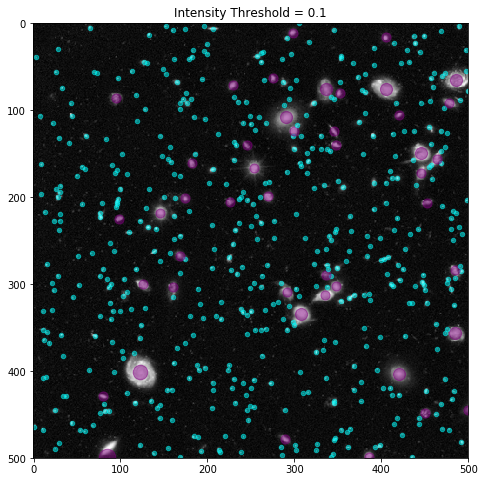

In [26]:
image = data.hubble_deep_field()[0:500, 0:500]
image_gray = rgb2gray(image)
for threshold in np.arange(0.1, 0.2, 0.1):
    blobs_log = blob_log(image_gray, max_sigma=30, num_sigma=10, threshold=threshold)
    plt.figure(figsize = (8, 8))
#     sigma_list = []
    for r, c, sigma in blobs_log:
        col = 'purple' if sigma > 4 else 'cyan'
        plt.scatter([c], [r], alpha=0.5, s=int(sigma*20), c=col)
#         sigma_list.append(sigma)
    plt.gca().invert_yaxis()
    plt.imshow(image_gray, cmap='gray')
    plt.title('Intensity Threshold = ' + str(round(threshold, 1)))
    plt.show()
#     plt.figure()
#     plt.hist(sigma_list)
#     plt.show()

## Using blob_log to detect spots in smFISH.png
Color larger blobs found purple, smaller blobs cyan.
Using min_sigma = min sigma found with gaussian fit spot parameter extraction (input: image. output: sigma of each spot). max_sigma likewise. threshold found by toggling.

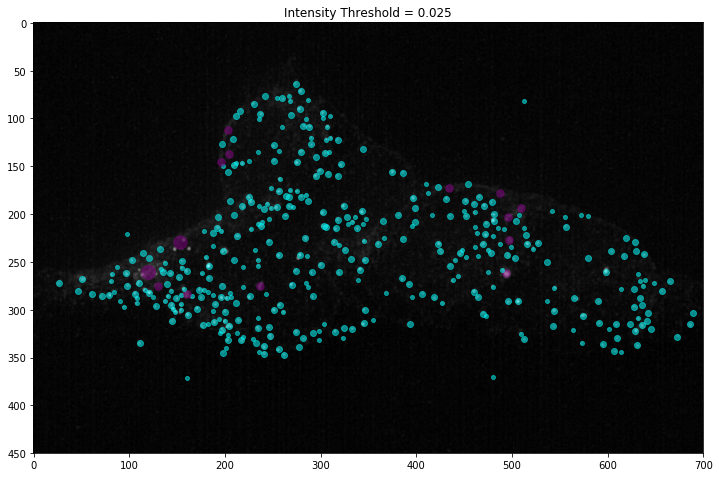

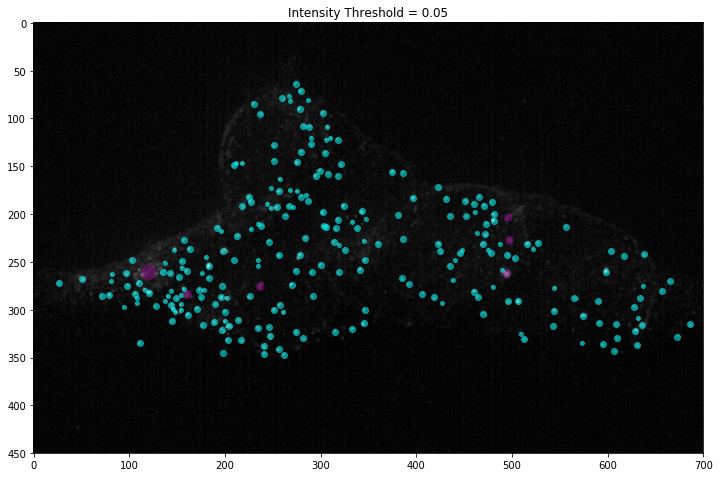

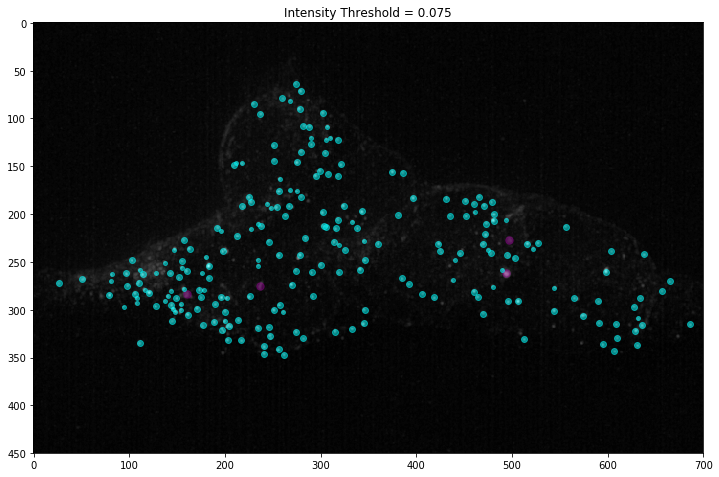

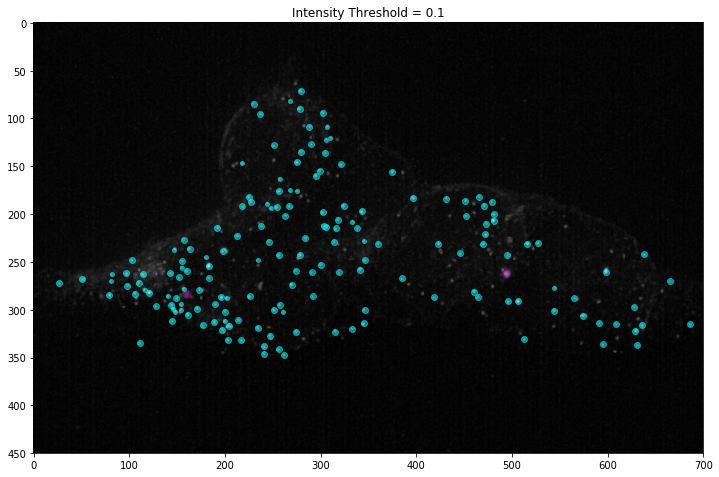

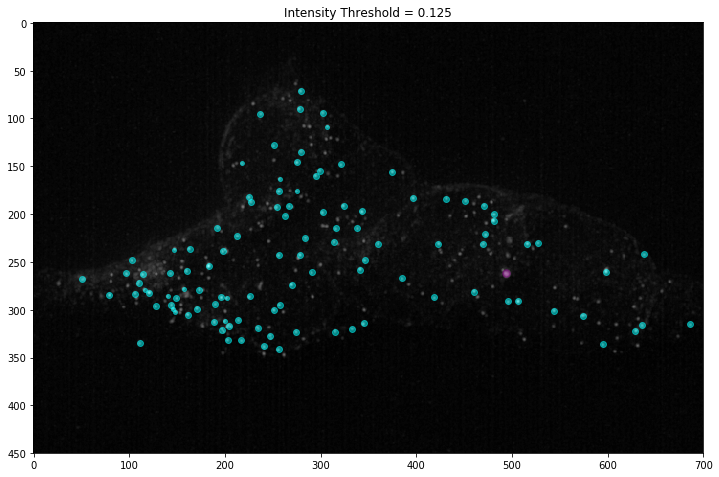

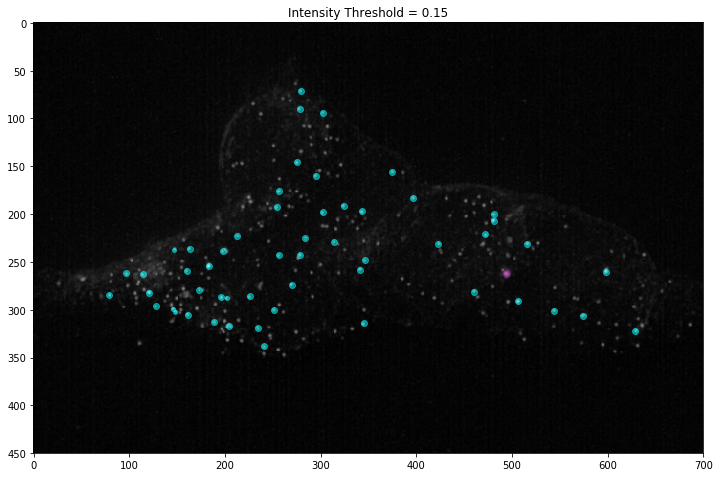

In [31]:
im = imread('smfish.png')
im_gray = rgb2gray(im)
for threshold in np.arange(0.025, 0.175, 0.025):
    blobs_log = blob_log(im, min_sigma=0.84, max_sigma=9.68, num_sigma=10, threshold=threshold)
    plt.figure(figsize = (12, 8))
#     sigma_list = []
    for r, c, sigma in blobs_log:
        col = 'purple' if sigma > 2 else 'cyan'
        plt.scatter([c], [r], alpha=0.5, s=int(sigma*20), c=col)
#         sigma_list.append(sigma)
    plt.gca().invert_yaxis()
    plt.imshow(im_gray, cmap='gray')
    plt.title('Intensity Threshold = ' + str(round(threshold, 3)))
    plt.show()
#     plt.figure()
#     plt.hist(sigma_list)
#     plt.show()

## Superimposing spots detected by blob_log with expert annotations.
Color larger blobs found purple, smaller blobs cyan, reference annotations yellow.

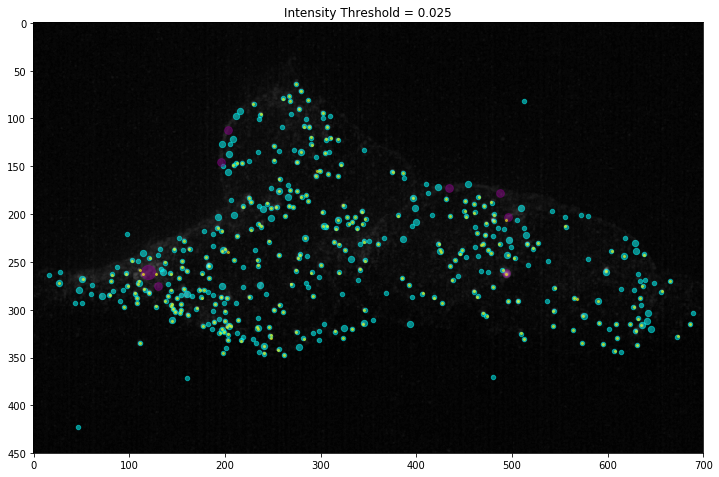

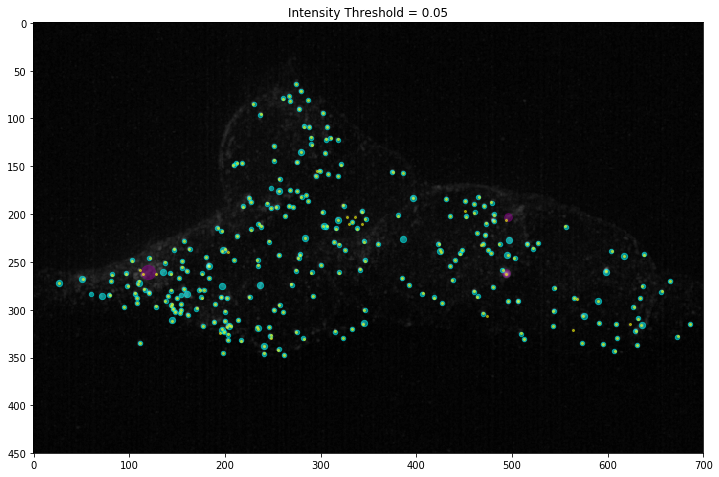

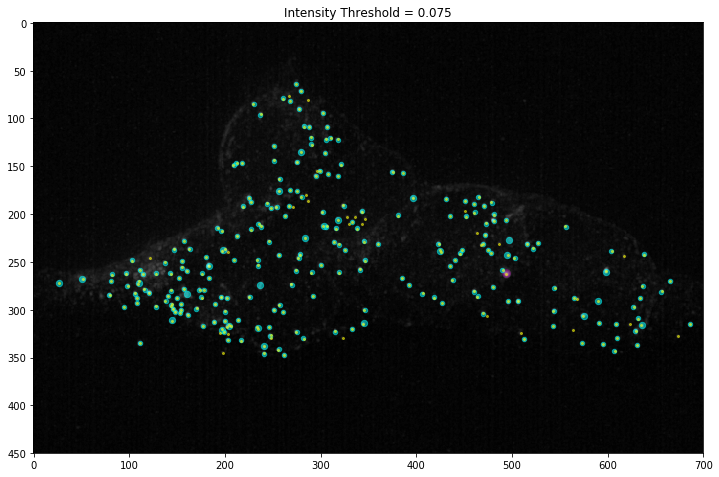

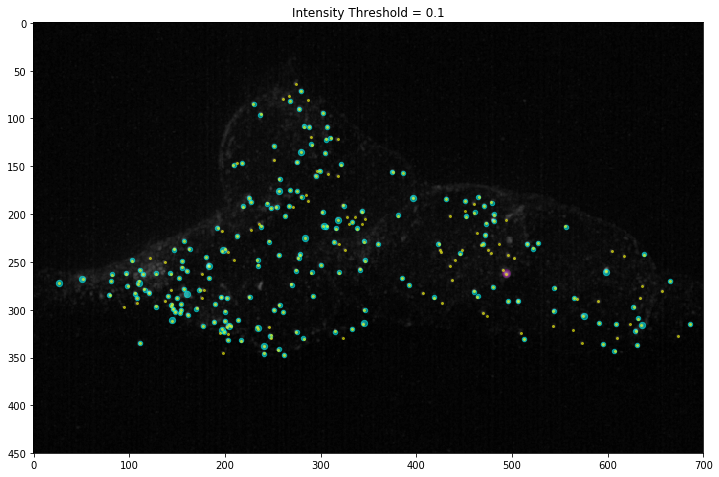

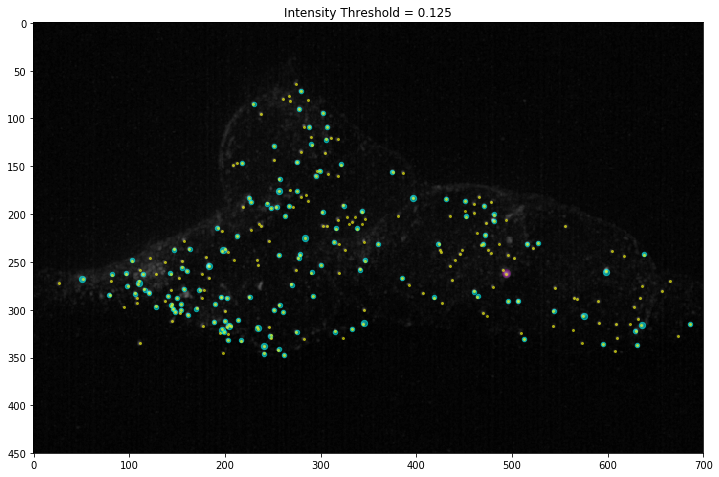

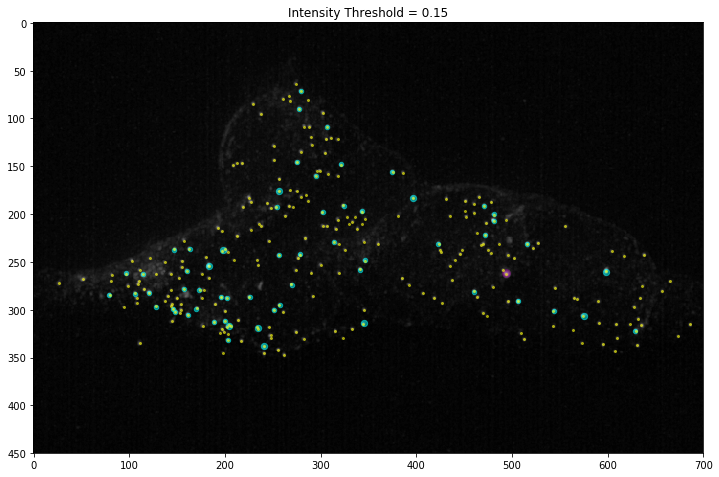

In [30]:
im = imread('smfish.png')
im_gray = rgb2gray(im)
coords = np.genfromtxt('smfish_coords.csv', delimiter=',')
for threshold in np.arange(0.025, 0.175, 0.025):
    blobs_log = blob_log(im, max_sigma=10, num_sigma=10, threshold=threshold)
    plt.figure(figsize = (12, 8))
    for r, c, sigma in blobs_log:
        col = 'purple' if sigma > 2 else 'cyan'
        plt.scatter([c], [r], alpha=0.5, s=int(sigma*20), c=col)
    for x, y in coords:
        plt.scatter(x, y, c='yellow', s=4, alpha=0.5)
    plt.gca().invert_yaxis()
    plt.imshow(im_gray, cmap='gray')
    plt.title('Intensity Threshold = ' + str(round(threshold, 3)))
    plt.show()


### Plot Precision-Recall.
(Can't really plot ROC because there aren't "true negatives."

In [3]:
from math import sqrt
from skimage import data
from skimage.feature import blob_dog, blob_log, blob_doh
from skimage.color import rgb2gray
from skimage.io import imread
import matplotlib.pyplot as plt
import numpy as np

In [8]:
from sklearn.neighbors import KDTree
import sys
sys.path.insert(0, '../FISH-annotation/Annotation')
import util

correctness_threshold = 4
print('Correctness threshold = ' + str(correctness_threshold) + ' pixels.')

ref_kdt = util.csv_to_kdt('smfish.csv', 450)

im = imread('smfish.png')
im_gray = rgb2gray(im)
ref_coords = np.genfromtxt('smfish_coords.csv', delimiter=',')

precision_list = []
recall_list = []

for threshold in np.arange(0.02, 0.18, 0.005):
    blobs_log = blob_log(im, max_sigma=10, num_sigma=10, threshold=threshold)
    blobs_list = []
    for r, c, sigma in blobs_log:
        blobs_list.append([c, r])
    blobs_kdt = KDTree(blobs_list, leaf_size=2, metric='euclidean')	# kdt is a kd tree with all the reference points
    
    num_blobs_total = len(blobs_log)
    num_ref_total = len(ref_coords)
    
    correct_blobs = []
    incorrect_blobs = []
    detected_ref = []
    undetected_ref = []
    
    # correct vs. incorrect
    
    for r, c, sigma in blobs_log:
        dist, ind = ref_kdt.query([[c, 450-r]], k=1)
        if dist[0][0] < correctness_threshold:
            correct_blobs.append((r, c, sigma))
        else:
            incorrect_blobs.append((r, c, sigma))
    
    # detected vs. undetected
        
    for x, y in ref_coords:
        dist, ind = blobs_kdt.query([[x, y]], k=1)
        if dist[0][0] < correctness_threshold:
            detected_ref.append([x, y])
        else:
            undetected_ref.append([x, y])
    
    num_ref_detected = len(detected_ref)
    num_blobs_correct = len(correct_blobs)
    
    # calculate precision and recall
    
    precision = len(correct_blobs)/(len(correct_blobs)+len(incorrect_blobs))
    recall = len(detected_ref)/(len(detected_ref)+len(undetected_ref))
    precision_list.append(precision)
    recall_list.append(recall)
    
    

Correctness threshold = 4 pixels.


## Precision Recall Curve

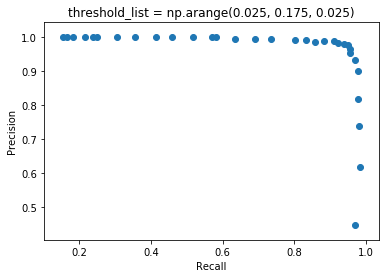

In [9]:
plt.figure()
plt.scatter(recall_list, precision_list)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('threshold_list = np.arange(0.025, 0.175, 0.025)')
plt.show()